In [1]:
import os

os.chdir("..")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from seasonal_color_analysis.core.classification import SeasonClassifier

In [3]:
# load labeled dataset

if os.path.exists("data/lfw_facenet_embeddings_label_spreading.parquet"):
    # try local path
    df = pd.read_parquet("data/lfw_facenet_embeddings_label_spreading.parquet")
else:
    # download from Hugging Face
    df = pd.read_parquet("hf://datasets/lajota13/lfw_facenet_embeddings/lfw_facenet_embeddings_label_spreading.parquet")
    df.to_parquet("data/lfw_facenet_embeddings_label_spreading.parquet")

df.head()

,original_path,embedding,name,season,macroseason,macrolabel
2,data/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckh...,"[-0.008572603575885296, -0.095662921667099, -0...",Aaron Eckhart,true-spring-celebrities,spring,2
97,data/lfw-deepfunneled/Adriana_Lima/Adriana_Lim...,"[0.03427708148956299, -0.037622347474098206, 0...",Adriana Lima,soft-summer-celebrities,summer,1
100,data/lfw-deepfunneled/Adrien_Brody/Adrien_Brod...,"[-0.02851502038538456, -0.07194815576076508, -...",Adrien Brody,bright-winter-celebrities,winter,0
101,data/lfw-deepfunneled/Adrien_Brody/Adrien_Brod...,"[-0.04232390597462654, -0.03775599226355553, -...",Adrien Brody,bright-winter-celebrities,winter,0
102,data/lfw-deepfunneled/Adrien_Brody/Adrien_Brod...,"[-0.026672080159187317, -0.03501059487462044, ...",Adrien Brody,bright-winter-celebrities,winter,0


In [4]:
CATEGORIES = ["winter", "summer", "spring", "autumn"]


class LabelEncoder:
  def __init__(self, classes: list[str]):
    self._classes = np.array(classes).reshape(1, -1)

  def transform(self, y: np.array):
    _y = y.reshape(-1, 1)
    assert (_y == self._classes).any(axis=-1).all(), "Label not in classes"
    return np.argmax(self._classes == _y, axis=-1)

  def inverse_transform(self, y: np.array):
    return self._classes[y.reshape(-1, 1)]


le = LabelEncoder(CATEGORIES)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
np_x_train = np.vstack(train_df["embedding"].tolist())
np_y_train = le.transform(train_df["macroseason"].values)
np_x_test = np.vstack(test_df["embedding"].tolist())
np_y_test = le.transform(test_df["macroseason"].values)

In [5]:
class SeasonDataset(torch.utils.data.Dataset):
  def __init__(self, np_x: np.ndarray, np_y: np.ndarray):
    self.X = torch.from_numpy(np_x).type(torch.float32)
    self.y = torch.from_numpy(np_y).type(torch.long)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx, :], self.y[idx]


ds_train = SeasonDataset(np_x_train, np_y_train)
ds_test = SeasonDataset(np_x_test, np_y_test)

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    # Compute prediction and loss
    for X, y in dataloader:
      logits = model(X)
      loss = loss_fn(logits, y)
      correct = (logits.argmax(1) == y).type(torch.float).sum().item()

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    return loss.item(), correct / y.shape[0]


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    for X, y in dataloader:
      with torch.no_grad():
        logits = model(X)
        test_loss = loss_fn(logits, y).item()
        correct = (logits.argmax(1) == y).type(torch.float).sum().item()
    return test_loss, correct / y.shape[0]

In [7]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 1048
epochs = 300

# Build model
model = SeasonClassifier(n_classes=4)

# Initialize the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define dataloaders
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [8]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
best_loss = np.inf
for t in tqdm(range(epochs)):
  _train_loss, _train_acc = train_loop(dataloader_train, model, loss_fn, optimizer)
  _test_loss, _test_acc = test_loop(dataloader_test, model, loss_fn)
  if _test_loss < best_loss:
    best_loss = _test_loss
    torch.save(model.state_dict(), 'data/classifier_weights_v1.pt')
  train_loss.append(_train_loss)
  train_acc.append(_train_acc)
  test_loss.append(_test_loss)
  test_acc.append(_test_acc)

  0%|          | 0/300 [00:00<?, ?it/s]

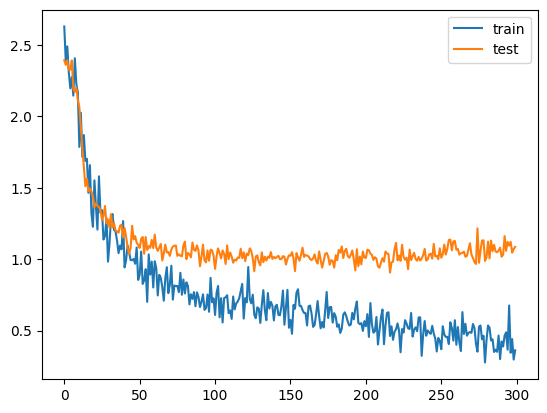

In [9]:
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.legend()

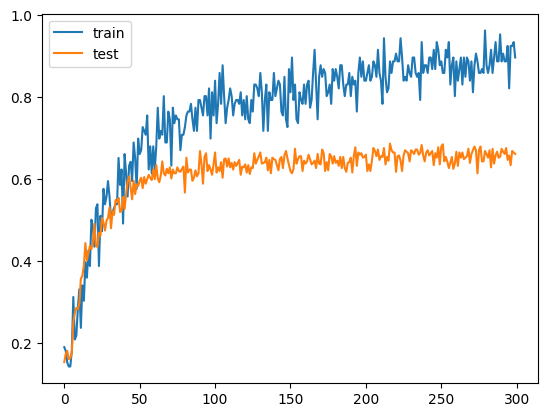

In [10]:
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()

<Axes: xlabel='x_norm', ylabel='y_norm'>

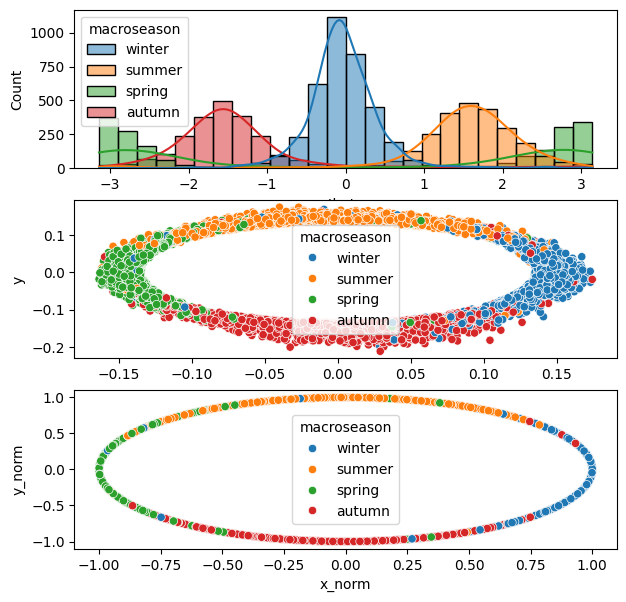

In [11]:
EPS = 1e-8

model.load_state_dict(torch.load("data/classifier_weights_v1.pt"))
model.eval()

x_train = torch.from_numpy(np_x_train).type(torch.float32)
_train_df = train_df.copy()
_train_df["theta"] = model.theta(x_train).detach().numpy()
embedding_train = model.embedding(x_train).detach().numpy()
_train_df["x"] = embedding_train[:, 0]
_train_df["y"] = embedding_train[:, 1]
_train_df["x_norm"] = (embedding_train / (np.linalg.norm(embedding_train, axis=-1)[:, None] + EPS))[:, 0]
_train_df["y_norm"] = (embedding_train / (np.linalg.norm(embedding_train, axis=-1)[:, None] + EPS))[:, 1]

plt.figure(figsize=(7, 7))
plt.subplot(3, 1, 1)
sns.histplot(_train_df, x="theta", hue="macroseason", kde=True)
plt.subplot(3, 1, 2)
sns.scatterplot(_train_df, x="x", y="y", hue="macroseason")
plt.subplot(3, 1, 3)
sns.scatterplot(_train_df, x="x_norm", y="y_norm", hue="macroseason")

<Axes: xlabel='x_norm', ylabel='y_norm'>

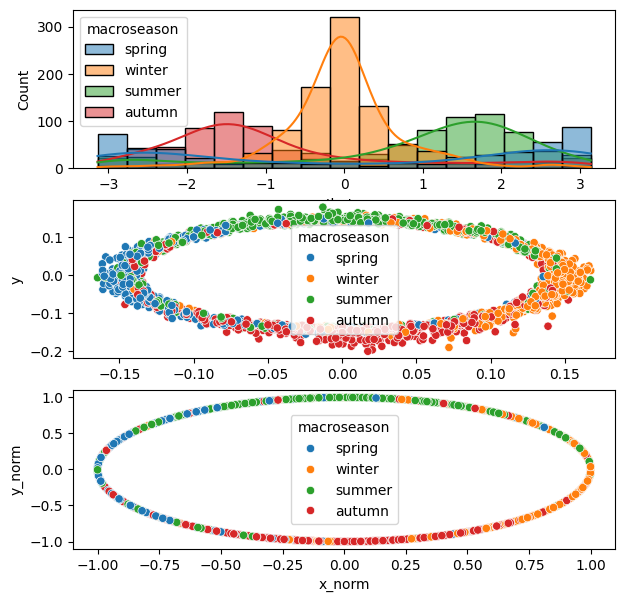

In [12]:
x_test = torch.from_numpy(np_x_test).type(torch.float32)
_test_df = test_df.copy()
_test_df["theta"] = model.theta(x_test).detach().numpy()
embedding_test = model.embedding(x_test).detach().numpy()
_test_df["x"] = embedding_test[:, 0]
_test_df["y"] = embedding_test[:, 1]
_test_df["x_norm"] = (embedding_test / (EPS + np.linalg.norm(embedding_test, axis=-1))[:, None])[:, 0]
_test_df["y_norm"] = (embedding_test / (EPS + np.linalg.norm(embedding_test, axis=-1))[:, None])[:, 1]

plt.figure(figsize=(7, 7))
plt.subplot(3, 1, 1)
sns.histplot(_test_df, x="theta", hue="macroseason", kde=True)
plt.subplot(3, 1, 2)
sns.scatterplot(_test_df, x="x", y="y", hue="macroseason")
plt.subplot(3, 1, 3)
sns.scatterplot(_test_df, x="x_norm", y="y_norm", hue="macroseason")

              precision    recall  f1-score   support

      winter       0.91      0.93      0.92      3770
      summer       0.87      0.84      0.85      2547
      spring       0.79      0.84      0.81      1958
      autumn       0.87      0.82      0.85      2311

    accuracy                           0.87     10586
   macro avg       0.86      0.86      0.86     10586
weighted avg       0.87      0.87      0.87     10586



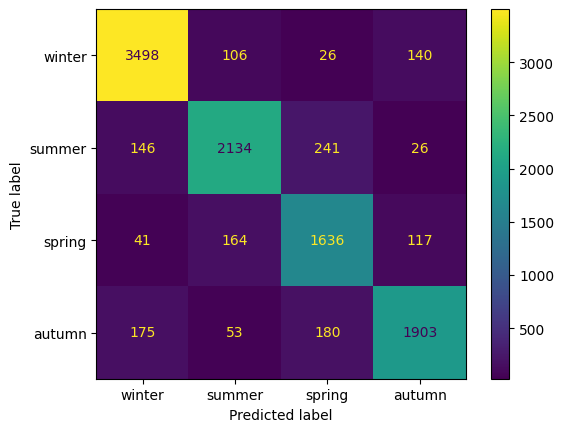

In [13]:
train_logits = model(x_train)
y_train_pred = train_logits.softmax(dim=-1).argmax(dim=-1).cpu().detach().numpy()
print(classification_report(y_pred=y_train_pred, y_true=np_y_train, target_names=CATEGORIES))
ConfusionMatrixDisplay.from_predictions(y_pred=y_train_pred, y_true=np_y_train, display_labels=CATEGORIES)

              precision    recall  f1-score   support

      winter       0.76      0.78      0.77       910
      summer       0.64      0.59      0.62       664
      spring       0.52      0.57      0.55       475
      autumn       0.62      0.60      0.61       598

    accuracy                           0.65      2647
   macro avg       0.64      0.64      0.64      2647
weighted avg       0.65      0.65      0.65      2647



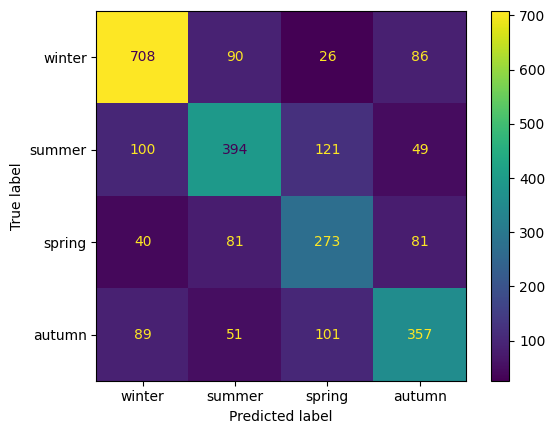

In [14]:
test_logits = model(x_test)
y_test_pred = test_logits.softmax(dim=-1).argmax(dim=-1).cpu().detach().numpy()
print(classification_report(y_pred=y_test_pred, y_true=np_y_test, target_names=CATEGORIES))
ConfusionMatrixDisplay.from_predictions(y_pred=y_test_pred, y_true=np_y_test, display_labels=CATEGORIES)

In [18]:
# dump season embeddings
_train_df[["name", "macroseason", "x", "y", "x_norm", "y_norm"]].to_parquet("data/lfw_season_embeddings_train.parquet")
_test_df[["name", "macroseason", "x", "y", "x_norm", "y_norm"]].to_parquet("data/lfw_season_embeddings_test.parquet")